<a href="https://colab.research.google.com/github/mfvc-campinho/M.EGI026-Computer-Vision-Assignment-2/blob/main/%5BMatheus%5D%20%5BM.EGI026%5D%20Assignment%20%232%20-%20VGG-19.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

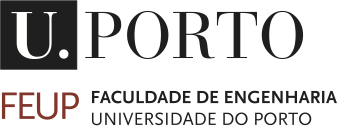   

**<h1>[M.EGI026] Computer Vision</h1>**

**<h2>Assignment #2 - XXX</h2>**

* **Filipa Mota** (up202402072@fe.up.pt)
* **Matheus Campinho** (up202402072@fe.up.pt)
<p> Department of Industrial Engineering and Management </p>  
FEUP  

----

**<h1>VGG - OK</h1>**

---
The below code cell first removes any existing content in the /content/ directory to ensure a clean slate. Then, it downloads a zip file containing the assignment data from a GitHub repository created for this purpose and extracts its contents into the /content/ directory. Finally, it prints the current directory path and lists the contents of the extracted folder.

**🛠️ Setup and Imports**

This cell imports the necessary libraries for the Computer Vision assignment:

xxx

In [ ]:
# ===== Import necessary Libraries =====
import re                       # Regular expressions library
import cv2 as cv                # OpenCV library
import numpy as np              # Numpy library
import glob                     # File pattern matching library
import os                       # Operating system library
import matplotlib.pyplot as plt # Matplotlib library
import pandas as pd             # Pandas library
import random                   # Random number generation library
import math                     # Math library
import json                     # JSON library for structured data handling

In [ ]:
# ===== Import necessary PyTorch modules =====
import torch                                # Main PyTorch library
import torch.nn as nn                       # Neural Network module
import torch.nn.functional as F             # Functional interface for neural networks
import torchvision                          # Computer vision library
import torchvision.transforms as transforms # Data augmentation and preprocessing
import torch.utils.data as data             # XXX
from tqdm.notebook import trange, tqdm      # XXX
from torch.optim import Adam, SGD, NAdam    # XXX
from torch.autograd import Variable         # XXX
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

**💾 Data Setup and Extraction**

This cell handles environment setup and data access in the Colab notebook:

* It **clears** the `/content/` directory.
* It **downloads** the necessary dataset ZIP file from GitHub.
* It **extracts** the files into the `/content/` directory.
* It **defines** the `path` variable for the extracted data, confirming successful setup.

In [ ]:
import os
import torch

# Limpar conteudo
!rm -rf /content/*

# DOWNLOAD do ZIP correto (o dataset real)
!wget -q -O /content/infrared.zip \
  "https://github.com/RaptorMaps/InfraredSolarModules/raw/master/2020-02-14_InfraredSolarModules.zip"

# EXTRAIR
!unzip -q /content/infrared.zip -d /content/

# Verificar conteúdo
print("📁 Conteúdo em /content:", os.listdir("/content"))

# Define your execution device
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") # Use GPU if available, else CPU
print("The model will be running on", DEVICE, "device...") # Confirm the device being used

📁 Conteúdo em /content: ['.config', 'infrared.zip', '__MACOSX', 'InfraredSolarModules']
The model will be running on cuda:0 device...


In [ ]:
from pathlib import Path
import json

data_dir = Path("/content/InfraredSolarModules")
meta_path = data_dir / "module_metadata.json"

with open(meta_path, "r") as f:
    metadata = json.load(f)

print("✔️ Metadata carregado:", len(metadata), "imagens")

✔️ Metadata carregado: 20000 imagens


**💾 CPU VS GPU**

Falta Descrição:
IMP: O GPU tem tempo máximo diário.

Para ativar:
* Vai à seccção Tempo de execução
* Clica em alterat tipo de tempo de execução
* Define Hardware Accelerator = GPU
* Reinicia o ambiente




In [ ]:
!nvidia-smi
torch.cuda.is_available()

Wed Dec  3 15:46:05 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   35C    P8              9W /   70W |       2MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

True

# Task
The first step is to implement dataset loading and exploration. This involves loading image paths and corresponding labels from the `metadata` dictionary, determining the unique classes and their distribution, implementing a custom PyTorch Dataset, and visualizing a few sample images along with their labels.

I will begin by extracting the image paths and anomaly classes from the loaded `metadata` and then analyze the class distribution.

✔️ Data Loaded.

Total images: 20000
Total labels: 20000

Unique classes: 12
Classes found: ['No-Anomaly' 'Cell' 'Hot-Spot' 'Offline-Module' 'Vegetation' 'Diode'
 'Shadowing' 'Cracking' 'Diode-Multi' 'Hot-Spot-Multi' 'Cell-Multi'
 'Soiling']

Class distribution:
No-Anomaly        10000
Cell               1877
Vegetation         1639
Diode              1499
Cell-Multi         1288
Shadowing          1056
Cracking            940
Offline-Module      827
Hot-Spot            249
Hot-Spot-Multi      246
Soiling             204
Diode-Multi         175
Name: count, dtype: int64


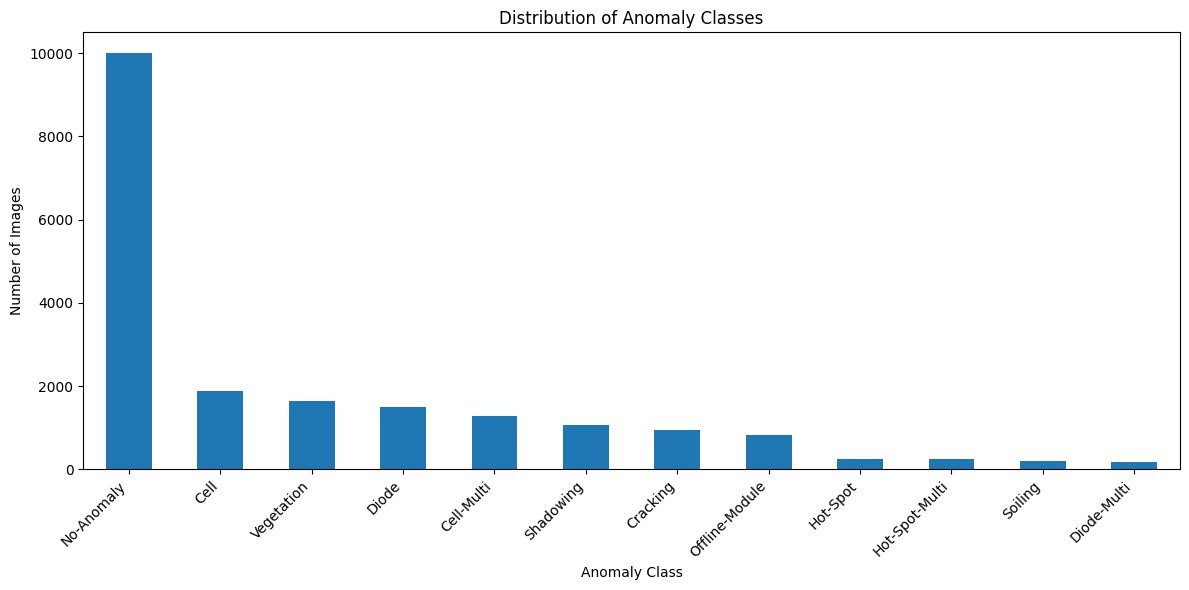

In [ ]:
# Implement Dataset Loading and Exploration

# 1. Load image paths and corresponding labels from the metadata
image_paths = []
labels = []
for module_id, data in metadata.items():
    image_paths.append(str(data_dir / data['image_filepath']))
    labels.append(data['anomaly_class'])

# Convert labels to a pandas Series for easy analysis
labels_series = pd.Series(labels)

# 2. Determine the unique classes and their distribution
unique_classes = labels_series.unique()
class_distribution = labels_series.value_counts()

print("✔️ Data Loaded.")
print(f"\nTotal images: {len(image_paths)}")
print(f"Total labels: {len(labels)}")
print(f"\nUnique classes: {len(unique_classes)}")
print("Classes found:", unique_classes)
print("\nClass distribution:")
print(class_distribution)

# Visualize the class distribution
plt.figure(figsize=(12, 6))
class_distribution.plot(kind='bar')
plt.title('Distribution of Anomaly Classes')
plt.xlabel('Anomaly Class')
plt.ylabel('Number of Images')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

## Implement Dataset Loading and Exploration

### Subtask:
Implement a custom PyTorch Dataset and visualize sample images.


**Reasoning**:
The first step is to extract all image file paths and their corresponding anomaly class labels from the loaded `metadata` dictionary. This will prepare the necessary lists for creating the custom PyTorch Dataset.



In [ ]:
image_paths = []
anomaly_labels = []

for img_id, info in metadata.items():
    image_paths.append(str(data_dir / info['image_filepath']))
    anomaly_labels.append(info['anomaly_class'])

print(f"Extracted {len(image_paths)} image paths and {len(anomaly_labels)} anomaly labels.")
print(f"First 5 image paths: {image_paths[:5]}")
print(f"First 5 anomaly labels: {anomaly_labels[:5]}")

Extracted 20000 image paths and 20000 anomaly labels.
First 5 image paths: ['/content/InfraredSolarModules/images/13357.jpg', '/content/InfraredSolarModules/images/13356.jpg', '/content/InfraredSolarModules/images/19719.jpg', '/content/InfraredSolarModules/images/11542.jpg', '/content/InfraredSolarModules/images/11543.jpg']
First 5 anomaly labels: ['No-Anomaly', 'No-Anomaly', 'No-Anomaly', 'No-Anomaly', 'No-Anomaly']


**Reasoning**:
I need to create a mapping from string labels to numerical indices and convert the `anomaly_labels` list accordingly, as per instructions 1 and 2 of the subtask. This is a prerequisite for creating the PyTorch Dataset which requires numerical labels.



In [ ]:
unique_classes = sorted(list(set(anomaly_labels)))
label_to_idx = {label: idx for idx, label in enumerate(unique_classes)}
idx_to_label = {idx: label for idx, label in enumerate(unique_classes)}

numerical_labels = [label_to_idx[label] for label in anomaly_labels]

print(f"Unique classes: {unique_classes}")
print(f"Label to index mapping: {label_to_idx}")
print(f"Index to label mapping: {idx_to_label}")
print(f"First 5 numerical labels: {numerical_labels[:5]}")

Unique classes: ['Cell', 'Cell-Multi', 'Cracking', 'Diode', 'Diode-Multi', 'Hot-Spot', 'Hot-Spot-Multi', 'No-Anomaly', 'Offline-Module', 'Shadowing', 'Soiling', 'Vegetation']
Label to index mapping: {'Cell': 0, 'Cell-Multi': 1, 'Cracking': 2, 'Diode': 3, 'Diode-Multi': 4, 'Hot-Spot': 5, 'Hot-Spot-Multi': 6, 'No-Anomaly': 7, 'Offline-Module': 8, 'Shadowing': 9, 'Soiling': 10, 'Vegetation': 11}
Index to label mapping: {0: 'Cell', 1: 'Cell-Multi', 2: 'Cracking', 3: 'Diode', 4: 'Diode-Multi', 5: 'Hot-Spot', 6: 'Hot-Spot-Multi', 7: 'No-Anomaly', 8: 'Offline-Module', 9: 'Shadowing', 10: 'Soiling', 11: 'Vegetation'}
First 5 numerical labels: [7, 7, 7, 7, 7]


**Reasoning**:
Now that the image paths and numerical labels are prepared, I need to define the custom PyTorch Dataset class, `InfraredDataset`, as specified in instruction 3 of the subtask. This class will handle loading images and their corresponding labels, and applying any specified transformations.



In [ ]:
from torch.utils.data import Dataset
from PIL import Image

class InfraredDataset(Dataset):
    def __init__(self, image_paths, labels, transform=None):
        self.image_paths = image_paths
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        image = Image.open(img_path).convert('RGB') # Ensure consistent RGB format
        label = self.labels[idx]

        if self.transform:
            image = self.transform(image)

        return image, label

print("✔️ InfraredDataset class defined.")

✔️ InfraredDataset class defined.


**Reasoning**:
I need to instantiate the `InfraredDataset` using the previously prepared `image_paths` and `numerical_labels`, along with a suitable `transform` for visualization, as specified in instruction 4 of the subtask. This transformation should prepare images for display without normalization to maintain original pixel values.



In [ ]:
transform_for_visualization = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize images to a common dimension
    transforms.ToTensor()          # Convert PIL Image to PyTorch Tensor (HWC to CHW, scale to 0-1)
])

# Instantiate the dataset
infrared_dataset = InfraredDataset(
    image_paths=image_paths,
    labels=numerical_labels,
    transform=transform_for_visualization
)

print(f"✔️ InfraredDataset instantiated with {len(infrared_dataset)} images.")
print(f"Sample image tensor shape: {infrared_dataset[0][0].shape}")
print(f"Sample label: {infrared_dataset[0][1]}")

✔️ InfraredDataset instantiated with 20000 images.
Sample image tensor shape: torch.Size([3, 224, 224])
Sample label: 7


**Reasoning**:
I need to select a few random indices, retrieve images and labels from the instantiated dataset, convert them to a suitable format for visualization, and display them in a grid with their corresponding string labels, as per instructions 5, 6, and 7 of the subtask.



Visualizing sample images...


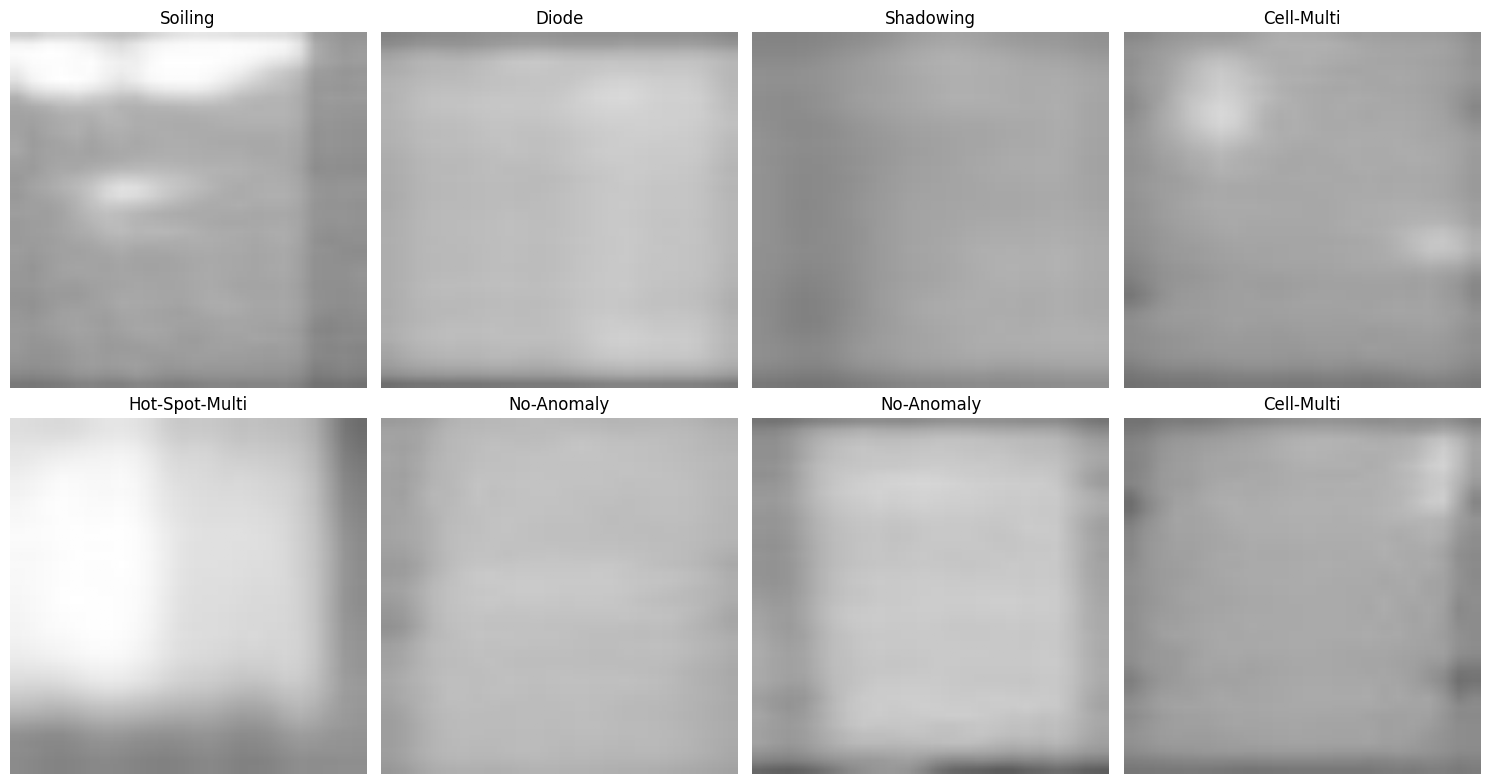

✔️ Sample images visualized.


In [ ]:
import matplotlib.pyplot as plt
import random

# 5. Select a few random indices (e.g., 8) from the dataset
sample_indices = random.sample(range(len(infrared_dataset)), 8)

# 7. Use matplotlib.pyplot to arrange and show these sample images in a grid
fig, axes = plt.subplots(2, 4, figsize=(15, 8))
axes = axes.flatten()

print("Visualizing sample images...")

# 6. For each selected index:
for i, idx in enumerate(sample_indices):
    # Retrieve the image (as a PyTorch tensor) and its numerical label
    image_tensor, numerical_label = infrared_dataset[idx]

    # Convert the numerical label back to its original string class name
    original_label = idx_to_label[numerical_label]

    # Convert the PyTorch image tensor to a NumPy array and rearrange its dimensions
    # from (C, H, W) to (H, W, C) for correct display with matplotlib
    image_np = image_tensor.numpy().transpose((1, 2, 0))

    # Display the image using plt.imshow()
    axes[i].imshow(image_np)
    # Set the title of each subplot to its corresponding original anomaly_class label
    axes[i].set_title(original_label)
    axes[i].axis('off') # Hide axes for cleaner look

plt.tight_layout()
plt.show()
print("✔️ Sample images visualized.")

## Define Data Preprocessing and Augmentation Transforms

### Subtask:
Create `torchvision.transforms` for data preprocessing and augmentation. Explain the utility of each augmentation for thermal PV imagery.


**Reasoning**:
I need to define the `train_transforms` pipeline according to the instructions, including both augmentation and preprocessing steps. This directly addresses instructions 1, 2, and 3 of the subtask.



In [ ]:
import torchvision.transforms as transforms

# 1, 2, 3. Define train_transforms pipeline with augmentation and preprocessing
train_transforms = transforms.Compose([
    transforms.RandomRotation(degrees=(-10, 10)),        # Rotate images by a small degree
    transforms.RandomHorizontalFlip(),                    # Flip images horizontally
    transforms.RandomVerticalFlip(),                      # Flip images vertically
    transforms.RandomResizedCrop(size=(224, 224), scale=(0.8, 1.0)), # Randomly crop and resize
    transforms.ColorJitter(brightness=0.2, contrast=0.2), # Randomly change brightness and contrast
    transforms.ToTensor(),                                # Convert PIL Image to PyTorch Tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]) # Normalize using ImageNet stats
])

print("✔️ train_transforms pipeline defined.")

✔️ train_transforms pipeline defined.


**Reasoning**:
I need to define a separate `val_test_transforms` pipeline for validation and testing, including only preprocessing steps, as specified in instructions 4 and 5 of the subtask.



In [ ]:
import torchvision.transforms as transforms

# 4, 5. Define val_test_transforms pipeline with only preprocessing steps
val_test_transforms = transforms.Compose([
    transforms.Resize((256, 256)),        # Resize the image to 256x256
    transforms.CenterCrop((224, 224)),    # Crop the center 224x224 portion
    transforms.ToTensor(),                # Convert PIL Image to PyTorch Tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]) # Normalize using ImageNet stats
])

print("✔️ val_test_transforms pipeline defined.")

✔️ val_test_transforms pipeline defined.


### Utility of Augmentation Techniques for Thermal PV Imagery

Data augmentation is crucial for training robust deep learning models, especially when dealing with limited datasets or diverse real-world conditions. For thermal Photovoltaic (PV) imagery, specific augmentations help simulate variations that naturally occur during data collection or due to environmental factors.

*   **`transforms.RandomRotation(degrees=(-10, 10))`**: This augmentation introduces slight rotational variations. In real-world thermal PV inspections, drones or cameras might not always capture images perfectly aligned. Random rotations help the model learn to recognize anomalies regardless of minor angular discrepancies in the image capture, improving its robustness to orientation changes of the solar panels or the camera itself.

*   **`transforms.RandomHorizontalFlip()`**: Thermal images of solar panels can often be symmetrical or semi-symmetrical. Flipping horizontally helps the model generalize across panels that might be installed in mirrored orientations or viewed from different sides, preventing it from learning features that are specific to a particular left-right arrangement.

*   **`transforms.RandomVerticalFlip()`**: Similar to horizontal flipping, vertical flipping accounts for possible variations in panel orientation (e.g., if panels are installed upside down or viewed from different elevations). This ensures the model learns to identify anomalies irrespective of their top-bottom position within the image.

*   **`transforms.RandomResizedCrop(size=(224, 224), scale=(0.8, 1.0))`**: This technique simulates variations in the scale and position of the solar panels within the frame. It helps the model become invariant to the exact framing of the image, allowing it to focus on the anomalous features themselves rather than their precise location or size relative to the image borders. It also acts as a form of regularization.

*   **`transforms.ColorJitter(brightness=0.2, contrast=0.2)`**: Thermal images, while often grayscale representations of temperature, can still exhibit variations in brightness and contrast due to differences in ambient temperature, solar irradiation, camera calibration, or atmospheric conditions. Color jittering (which for single-channel thermal images effectively means brightness and contrast jittering) helps the model become more resilient to these lighting and thermal intensity fluctuations, ensuring it can identify anomalies under a broader range of operational environments.

## Split Dataset and Create DataLoaders

### Subtask:
Split the dataset into training, validation, and test sets, ensuring a stratified split. Instantiate PyTorch `DataLoader` objects for each set, applying the appropriate preprocessing/augmentation transforms.


## Split Dataset and Create DataLoaders

### Subtask:
Split the dataset into training, validation, and test sets, ensuring a stratified split. Instantiate PyTorch `DataLoader` objects for each set, applying the appropriate preprocessing/augmentation transforms.

#### Instructions
1. Import `train_test_split` from `sklearn.model_selection`.
2. Split the `image_paths` and `numerical_labels` into training (80%), validation (10%), and test (10%) sets. Ensure a stratified split based on `numerical_labels` to maintain class distribution across splits.
3. Create three instances of the `InfraredDataset` class:
    * One for the training set, applying `train_transforms`.
    * One for the validation set, applying `val_test_transforms`.
    * One for the test set, applying `val_test_transforms`.
4. Define a suitable `batch_size` (e.g., 32 or 64).
5. Create three PyTorch `DataLoader` objects:
    * `train_loader` using the training dataset, with `shuffle=True`.
    * `val_loader` using the validation dataset, with `shuffle=False`.
    * `test_loader` using the test dataset, with `shuffle=False`.
6. Print the number of samples in each dataset split (train, validation, test) and the number of batches in each DataLoader to confirm the split and loading process.

**Reasoning**:
The first step in the subtask is to import `train_test_split` from `sklearn.model_selection` to prepare for splitting the dataset. I will import this in a `code_block`.



In [ ]:
from sklearn.model_selection import train_test_split

print("✔️ `train_test_split` imported successfully.")

✔️ `train_test_split` imported successfully.


**Reasoning**:
I need to split the `image_paths` and `numerical_labels` into training, validation, and test sets with an 80/10/10 ratio, ensuring the split is stratified by `numerical_labels` to maintain class distribution, as per instruction 2 of the subtask.



In [ ]:
X = image_paths
y = numerical_labels

# First, split into training (80%) and a combined validation+test set (20%)
X_train, X_val_test, y_train, y_val_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Then, split the combined validation+test set into validation (10%) and test (10%)
# This is done by taking half (0.5) of the remaining 20%, which gives 10% of the total
X_val, X_test, y_val, y_test = train_test_split(
    X_val_test, y_val_test, test_size=0.5, random_state=42, stratify=y_val_test
)

print(f"✔️ Dataset split into training, validation, and test sets.")
print(f"Train set size: {len(X_train)} samples")
print(f"Validation set size: {len(X_val)} samples")
print(f"Test set size: {len(X_test)} samples")

✔️ Dataset split into training, validation, and test sets.
Train set size: 16000 samples
Validation set size: 2000 samples
Test set size: 2000 samples


**Reasoning**:
I need to create three instances of the `InfraredDataset` class for the training, validation, and test sets, applying `train_transforms` to the training set and `val_test_transforms` to the validation and test sets, as specified in instruction 3 of the subtask.



In [ ]:
train_dataset = InfraredDataset(X_train, y_train, transform=train_transforms)
val_dataset = InfraredDataset(X_val, y_val, transform=val_test_transforms)
test_dataset = InfraredDataset(X_test, y_test, transform=val_test_transforms)

print("✔️ InfraredDataset instances created for train, validation, and test sets.")
print(f"Train dataset size: {len(train_dataset)} samples")
print(f"Validation dataset size: {len(val_dataset)} samples")
print(f"Test dataset size: {len(test_dataset)} samples")

✔️ InfraredDataset instances created for train, validation, and test sets.
Train dataset size: 16000 samples
Validation dataset size: 2000 samples
Test dataset size: 2000 samples


**Reasoning**:
I need to define the `batch_size` and create the PyTorch `DataLoader` objects for the training, validation, and test sets, applying the specified shuffling, as per instructions 4 and 5 of the subtask. Finally, I will print the number of samples and batches for each, as required by instruction 6.



In [ ]:
from torch.utils.data import DataLoader

# 4. Define a suitable batch_size
batch_size = 32

# 5. Create three PyTorch DataLoader objects
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

print(f"\n✔️ DataLoader objects created with batch_size={batch_size}.")
# 6. Print the number of samples in each dataset split and the number of batches in each DataLoader
print(f"Train DataLoader: {len(train_loader)} batches (total {len(train_dataset)} samples)")
print(f"Validation DataLoader: {len(val_loader)} batches (total {len(val_dataset)} samples)")
print(f"Test DataLoader: {len(test_loader)} batches (total {len(test_dataset)} samples)")


✔️ DataLoader objects created with batch_size=32.
Train DataLoader: 500 batches (total 16000 samples)
Validation DataLoader: 63 batches (total 2000 samples)
Test DataLoader: 63 batches (total 2000 samples)


## Define VGG-19 Model Architecture

### Subtask:
Load a pre-trained VGG-19 model, modify its final classification layer to match the number of defect categories, optionally freeze earlier layers, and display a model summary.


**Reasoning**:
The first step is to import the `vgg19` model from `torchvision.models` and load a pre-trained version, as per instruction 1 of the subtask. This will provide the base model for modification.



In [ ]:
import torchvision.models as models

# 1. Import the vgg19 model and load a pre-trained version
model = models.vgg19(pretrained=True)

print("✔️ Pre-trained VGG-19 model loaded successfully.")

/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth


100%|██████████| 548M/548M [00:03<00:00, 188MB/s]


✔️ Pre-trained VGG-19 model loaded successfully.


**Reasoning**:
I need to access and modify the VGG-19 model's classifier, freeze the feature layers, move the model to the designated device, and then generate a model summary as per instructions 2-7 of the subtask.



In [ ]:
# 2, 3, 4. Access, identify input features, and modify the final classification layer
num_classes = len(unique_classes) # Use the previously determined number of unique classes

# Get the number of in_features of the last classification layer
in_features = model.classifier[-1].in_features

# Replace the last layer with a new one for the correct number of classes
model.classifier[-1] = nn.Linear(in_features, num_classes)

print(f"✔️ Modified VGG-19 classifier. Output features: {model.classifier[-1].out_features}")

# 5. (Optional) Freeze earlier layers (feature extraction layers)
for param in model.features.parameters():
    param.requires_grad = False

print("✔️ Feature layers frozen for fine-tuning.")

# 6. Move the model to the appropriate device
model = model.to(DEVICE)

print(f"✔️ Model moved to {DEVICE}.")

# 7. Print a summary of the modified model
# Install torchsummary if not already installed
try:
    import torchsummary
except ImportError:
    print("Installing torchsummary...")
    !pip install torchsummary
    import torchsummary

print("\n--- Model Summary ---")
torchsummary.summary(model, (3, 224, 224))
print("---------------------")

✔️ Modified VGG-19 classifier. Output features: 12
✔️ Feature layers frozen for fine-tuning.
✔️ Model moved to cuda:0.

--- Model Summary ---
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 224, 224]           1,792
              ReLU-2         [-1, 64, 224, 224]               0
            Conv2d-3         [-1, 64, 224, 224]          36,928
              ReLU-4         [-1, 64, 224, 224]               0
         MaxPool2d-5         [-1, 64, 112, 112]               0
            Conv2d-6        [-1, 128, 112, 112]          73,856
              ReLU-7        [-1, 128, 112, 112]               0
            Conv2d-8        [-1, 128, 112, 112]         147,584
              ReLU-9        [-1, 128, 112, 112]               0
        MaxPool2d-10          [-1, 128, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]         295,168
             ReLU-12     

## Set Up Training Parameters

### Subtask:
Define the loss function, optimizer, and optionally a learning rate scheduler.


**Reasoning**:
The first instruction is to define the loss function as `nn.CrossEntropyLoss` and move it to the appropriate device (CPU/GPU).



In [ ]:
import torch.nn as nn
import torch.optim as optim

# 1. Define the loss function
criterion = nn.CrossEntropyLoss().to(DEVICE)

print(f"✔️ Loss function (CrossEntropyLoss) defined and moved to {DEVICE}.")

✔️ Loss function (CrossEntropyLoss) defined and moved to cuda:0.


**Reasoning**:
I need to choose an optimizer (`torch.optim.Adam`) and initialize it with the model's parameters that require gradients and a suitable learning rate, as per instruction 2 of the subtask.



In [ ]:
import torch.optim as optim

# 2. Choose an optimizer and initialize it
optimizer = optim.Adam(model.parameters(), lr=0.001)

print("✔️ Optimizer (Adam) defined.")

✔️ Optimizer (Adam) defined.


**Reasoning**:
I need to optionally define a learning rate scheduler, for example, `torch.optim.lr_scheduler.StepLR`, to adjust the learning rate during training, as per instruction 3 of the subtask.



In [ ]:
import torch.optim.lr_scheduler as lr_scheduler

# 3. Optionally, define a learning rate scheduler
scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

print("✔️ Learning rate scheduler (StepLR) defined.")

✔️ Learning rate scheduler (StepLR) defined.


## Implement Model Training Loop

### Subtask:
Develop the training loop to train the VGG-19 model for 20-40 epochs. Include steps for forward pass, backpropagation, and optimizer updates. Monitor and record training and validation loss and accuracy per epoch. Ensure the model is moved to the appropriate device (GPU/CPU).


**Reasoning**:
The first step is to define the number of epochs for training and initialize empty lists to store the training and validation metrics, as specified in instructions 1 and 2 of the subtask. This prepares the variables needed for the training loop.



In [ ]:
num_epochs = 20

train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

print(f"✔️ Training setup: {num_epochs} epochs defined. Metric lists initialized.")

✔️ Training setup: 20 epochs defined. Metric lists initialized.


## Implement Model Training Loop

### Subtask:
Develop the training loop to train the VGG-19 model for 20-40 epochs. Include steps for forward pass, backpropagation, and optimizer updates. Monitor and record training and validation loss and accuracy per epoch. Ensure the model is moved to the appropriate device (GPU/CPU).

#### Instructions
1.  **Define `train_one_epoch` function**:
    *   Set the model to training mode.
    *   Initialize running loss and correct predictions for the epoch.
    *   Iterate through the `train_loader` using `tqdm` for progress.
    *   Move inputs and labels to the `DEVICE`.
    *   Perform a forward pass: `outputs = model(inputs)`.
    *   Calculate loss: `loss = criterion(outputs, labels)`.
    *   Perform backpropagation: `optimizer.zero_grad()`, `loss.backward()`, `optimizer.step()`.
    *   Update running loss and count correct predictions.
    *   Return average epoch loss and accuracy.
2.  **Define `validate_one_epoch` function**:
    *   Set the model to evaluation mode (`model.eval()`).
    *   Initialize running loss and correct predictions.
    *   Use `torch.no_grad()` context manager.
    *   Iterate through the `val_loader` using `tqdm` for progress.
    *   Move inputs and labels to the `DEVICE`.
    *   Perform a forward pass: `outputs = model(inputs)`.
    *   Calculate loss: `loss = criterion(outputs, labels)`.
    *   Update running loss and count correct predictions.
    *   Return average epoch loss and accuracy.
3.  **Implement the main training loop**:
    *   Loop for `num_epochs`.
    *   Call `train_one_epoch` and record its output.
    *   Call `validate_one_epoch` and record its output.
    *   Update the learning rate scheduler (`scheduler.step()`) if defined.
    *   Print epoch summary (epoch number, train loss, train accuracy, val loss, val accuracy).
    *   Store epoch metrics in the `train_losses`, `train_accuracies`, `val_losses`, `val_accuracies` lists.
    *   Optionally, save the best model based on validation accuracy.

## Define `train_one_epoch` function

### Subtask:
Implement the training function for one epoch, including forward pass, backpropagation, and metric updates.


**Reasoning**:
I need to define the `train_one_epoch` function as per the instructions, which includes setting the model to training mode, iterating through the data loader, performing forward and backward passes, updating the optimizer, and calculating epoch-level loss and accuracy. I will include `epoch` as an argument for the `tqdm` progress bar.



In [ ]:
from tqdm.notebook import tqdm

def train_one_epoch(model, train_loader, criterion, optimizer, DEVICE, epoch):
    # 2. Set the model to training mode
    model.train()

    # 3. Initialize running_loss and correct_predictions
    running_loss = 0.0
    correct_predictions = 0
    # 4. Get the total number of samples processed for the epoch
    total_samples = 0

    # 5. Iterate through the train_loader with a tqdm progress bar
    for inputs, labels in tqdm(train_loader, desc=f'Training Epoch {epoch + 1}'):
        # 6. Move the inputs and labels to the DEVICE
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)

        # 7. Zero out the gradients of the optimizer
        optimizer.zero_grad()

        # 8. Perform a forward pass
        outputs = model(inputs)

        # 9. Calculate the loss
        loss = criterion(outputs, labels)

        # 10. Perform backpropagation
        loss.backward()

        # 11. Update the model's weights
        optimizer.step()

        # 12. Update running_loss
        running_loss += loss.item() * inputs.size(0)

        # 13. Calculate predictions
        _, predicted = torch.max(outputs.data, 1)

        # 14. Update correct_predictions
        correct_predictions += (predicted == labels).sum().item()

        # 15. Update total_samples
        total_samples += inputs.size(0)

    # 16. Calculate the epoch_loss
    epoch_loss = running_loss / total_samples

    # 17. Calculate the epoch_accuracy
    epoch_accuracy = correct_predictions / total_samples * 100

    # 18. Return epoch_loss and epoch_accuracy
    return epoch_loss, epoch_accuracy

print("✔️ `train_one_epoch` function defined.")

✔️ `train_one_epoch` function defined.


## Define `validate_one_epoch` function

### Subtask:
Implement the validation function for one epoch, including forward pass, and metric updates without backpropagation.

**Reasoning**:
Now I need to define the `validate_one_epoch` function as per the instructions, which includes setting the model to evaluation mode, iterating through the data loader, performing a forward pass, and calculating epoch-level loss and accuracy without backpropagation. I will include `epoch` as an argument for the `tqdm` progress bar.



In [ ]:
from tqdm.notebook import tqdm

def validate_one_epoch(model, val_loader, criterion, DEVICE, epoch):
    # 1. Set the model to evaluation mode
    model.eval()

    # 2. Initialize running_loss and correct_predictions
    running_loss = 0.0
    correct_predictions = 0
    # Get the total number of samples processed for the epoch
    total_samples = 0

    # 3. Use torch.no_grad() context manager to disable gradient calculation
    with torch.no_grad():
        # 4. Iterate through the val_loader with a tqdm progress bar
        for inputs, labels in tqdm(val_loader, desc=f'Validation Epoch {epoch + 1}'):
            # 5. Move the inputs and labels to the DEVICE
            inputs = inputs.to(DEVICE)
            labels = labels.to(DEVICE)

            # 6. Perform a forward pass
            outputs = model(inputs)

            # 7. Calculate the loss
            loss = criterion(outputs, labels)

            # 8. Update running_loss
            running_loss += loss.item() * inputs.size(0)

            # 9. Calculate predictions
            _, predicted = torch.max(outputs.data, 1)

            # 10. Update correct_predictions
            correct_predictions += (predicted == labels).sum().item()

            # 11. Update total_samples
            total_samples += inputs.size(0)

    # 12. Calculate the epoch_loss
    epoch_loss = running_loss / total_samples

    # 13. Calculate the epoch_accuracy
    epoch_accuracy = correct_predictions / total_samples * 100

    # 14. Return epoch_loss and epoch_accuracy
    return epoch_loss, epoch_accuracy

print("✔️ `validate_one_epoch` function defined.")

✔️ `validate_one_epoch` function defined.


## Implement the main training loop

### Subtask:
Implement the main training loop, which iterates over epochs, calls `train_one_epoch` and `validate_one_epoch`, updates the learning rate scheduler, and logs metrics.

**Reasoning**:
Now that both `train_one_epoch` and `validate_one_epoch` functions are defined, I need to implement the main training loop that orchestrates these functions, updates the learning rate scheduler, prints epoch summaries, and stores metrics, as per instruction 3 of the subtask. I will also include logic to save the best model.



In [ ]:
best_val_accuracy = 0.0

for epoch in range(num_epochs):
    # Train the model for one epoch
    train_loss, train_accuracy = train_one_epoch(model, train_loader, criterion, optimizer, DEVICE, epoch)
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)

    # Validate the model for one epoch
    val_loss, val_accuracy = validate_one_epoch(model, val_loader, criterion, DEVICE, epoch)
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)

    # Update the learning rate scheduler
    scheduler.step()

    # Print epoch summary
    print(f"Epoch {epoch + 1}/{num_epochs}:\n"
          f"  Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%\n"
          f"  Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.2f}%")

    # Optionally, save the best model based on validation accuracy
    if val_accuracy > best_val_accuracy:
        best_val_accuracy = val_accuracy
        torch.save(model.state_dict(), 'best_vgg19_model.pth')
        print("  >> Saved best model with validation accuracy: {:.2f}%".format(best_val_accuracy))

print("\n✔️ Model training complete.")

Training Epoch 1:   0%|          | 0/500 [00:00<?, ?it/s]

Validation Epoch 1:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 1/20:
  Train Loss: 1.8209, Train Accuracy: 48.17%
  Val Loss: 1.5538, Val Accuracy: 53.50%
  >> Saved best model with validation accuracy: 53.50%


Training Epoch 2:   0%|          | 0/500 [00:00<?, ?it/s]

Validation Epoch 2:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 2/20:
  Train Loss: 1.7240, Train Accuracy: 50.92%
  Val Loss: 1.5199, Val Accuracy: 54.85%
  >> Saved best model with validation accuracy: 54.85%


Training Epoch 3:   0%|          | 0/500 [00:00<?, ?it/s]

Validation Epoch 3:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 3/20:
  Train Loss: 1.6267, Train Accuracy: 52.67%
  Val Loss: 1.4516, Val Accuracy: 56.25%
  >> Saved best model with validation accuracy: 56.25%


Training Epoch 4:   0%|          | 0/500 [00:00<?, ?it/s]

Validation Epoch 4:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 4/20:
  Train Loss: 1.6169, Train Accuracy: 53.12%
  Val Loss: 1.4845, Val Accuracy: 55.70%


Training Epoch 5:   0%|          | 0/500 [00:00<?, ?it/s]

Validation Epoch 5:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 5/20:
  Train Loss: 1.5811, Train Accuracy: 53.91%
  Val Loss: 1.4536, Val Accuracy: 56.65%
  >> Saved best model with validation accuracy: 56.65%


Training Epoch 6:   0%|          | 0/500 [00:00<?, ?it/s]

Validation Epoch 6:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 6/20:
  Train Loss: 1.5551, Train Accuracy: 54.42%
  Val Loss: 1.4735, Val Accuracy: 57.15%
  >> Saved best model with validation accuracy: 57.15%


Training Epoch 7:   0%|          | 0/500 [00:00<?, ?it/s]

Validation Epoch 7:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 7/20:
  Train Loss: 1.5451, Train Accuracy: 54.75%
  Val Loss: 1.5112, Val Accuracy: 54.95%


Training Epoch 8:   0%|          | 0/500 [00:00<?, ?it/s]

Validation Epoch 8:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 8/20:
  Train Loss: 1.4775, Train Accuracy: 56.24%
  Val Loss: 1.4263, Val Accuracy: 57.10%


Training Epoch 9:   0%|          | 0/500 [00:00<?, ?it/s]

Validation Epoch 9:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 9/20:
  Train Loss: 1.4508, Train Accuracy: 56.79%
  Val Loss: 1.4184, Val Accuracy: 57.60%
  >> Saved best model with validation accuracy: 57.60%


Training Epoch 10:   0%|          | 0/500 [00:00<?, ?it/s]

Validation Epoch 10:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 10/20:
  Train Loss: 1.4163, Train Accuracy: 57.69%
  Val Loss: 1.4064, Val Accuracy: 57.85%
  >> Saved best model with validation accuracy: 57.85%


Training Epoch 11:   0%|          | 0/500 [00:00<?, ?it/s]

Validation Epoch 11:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 11/20:
  Train Loss: 1.4150, Train Accuracy: 57.39%
  Val Loss: 1.4072, Val Accuracy: 57.60%


Training Epoch 12:   0%|          | 0/500 [00:00<?, ?it/s]

Validation Epoch 12:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 12/20:
  Train Loss: 1.3961, Train Accuracy: 57.83%
  Val Loss: 1.3947, Val Accuracy: 58.40%
  >> Saved best model with validation accuracy: 58.40%


Training Epoch 13:   0%|          | 0/500 [00:00<?, ?it/s]

Validation Epoch 13:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 13/20:
  Train Loss: 1.3921, Train Accuracy: 58.03%
  Val Loss: 1.3855, Val Accuracy: 58.20%


Training Epoch 14:   0%|          | 0/500 [00:00<?, ?it/s]

Validation Epoch 14:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 14/20:
  Train Loss: 1.3662, Train Accuracy: 58.68%
  Val Loss: 1.3694, Val Accuracy: 58.70%
  >> Saved best model with validation accuracy: 58.70%


Training Epoch 15:   0%|          | 0/500 [00:00<?, ?it/s]

Validation Epoch 15:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 15/20:
  Train Loss: 1.3569, Train Accuracy: 58.75%
  Val Loss: 1.3699, Val Accuracy: 58.60%


Training Epoch 16:   0%|          | 0/500 [00:00<?, ?it/s]

Validation Epoch 16:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 16/20:
  Train Loss: 1.3663, Train Accuracy: 58.79%
  Val Loss: 1.3682, Val Accuracy: 58.60%


Training Epoch 17:   0%|          | 0/500 [00:00<?, ?it/s]

Validation Epoch 17:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 17/20:
  Train Loss: 1.3561, Train Accuracy: 58.93%
  Val Loss: 1.3694, Val Accuracy: 58.70%


Training Epoch 18:   0%|          | 0/500 [00:00<?, ?it/s]

Validation Epoch 18:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 18/20:
  Train Loss: 1.3517, Train Accuracy: 58.63%
  Val Loss: 1.3678, Val Accuracy: 58.60%


Training Epoch 19:   0%|          | 0/500 [00:00<?, ?it/s]

Validation Epoch 19:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 19/20:
  Train Loss: 1.3539, Train Accuracy: 58.89%
  Val Loss: 1.3647, Val Accuracy: 58.80%
  >> Saved best model with validation accuracy: 58.80%


Training Epoch 20:   0%|          | 0/500 [00:00<?, ?it/s]

Validation Epoch 20:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 20/20:
  Train Loss: 1.3484, Train Accuracy: 58.91%
  Val Loss: 1.3646, Val Accuracy: 59.05%
  >> Saved best model with validation accuracy: 59.05%

✔️ Model training complete.


## Plot Training and Validation Curves

### Subtask:
Plot the recorded training and validation accuracy and loss curves over epochs using `matplotlib`.


**Reasoning**:
I need to plot the recorded training and validation loss and accuracy curves over epochs using `matplotlib.pyplot`, as per the subtask instructions. This involves creating two subplots and plotting the respective data with appropriate labels and titles.



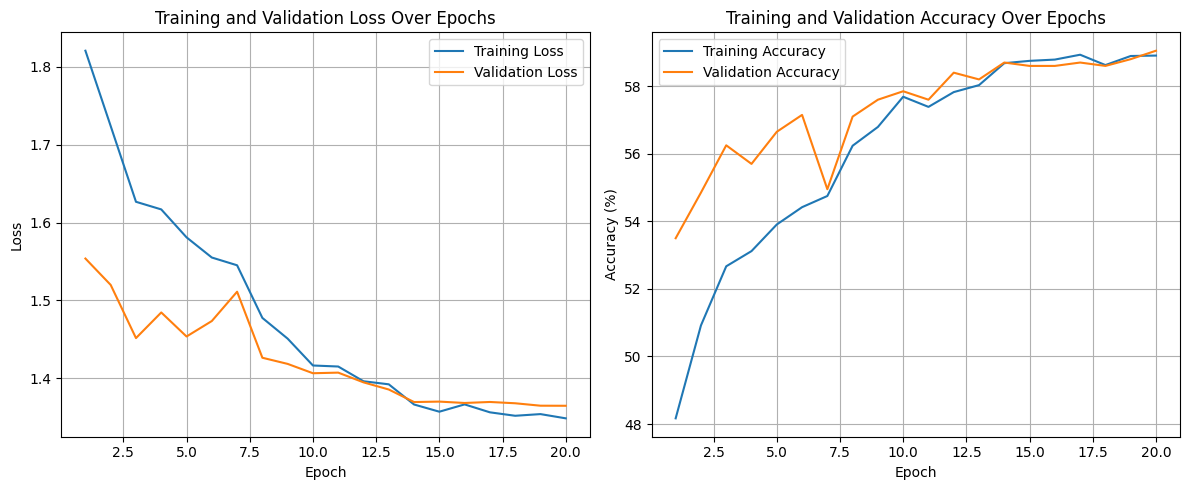

✔️ Training and validation curves plotted.


In [ ]:
import matplotlib.pyplot as plt

epochs = range(1, num_epochs + 1)

plt.figure(figsize=(12, 5))

# Subplot for Loss
plt.subplot(1, 2, 1)
plt.plot(epochs, train_losses, label='Training Loss')
plt.plot(epochs, val_losses, label='Validation Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# Subplot for Accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs, train_accuracies, label='Training Accuracy')
plt.plot(epochs, val_accuracies, label='Validation Accuracy')
plt.title('Training and Validation Accuracy Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

print("✔️ Training and validation curves plotted.")

## Evaluate Model on Test Set

### Subtask:
Evaluate the trained model on the unseen test set, calculate key performance metrics, and generate a confusion matrix.


**Reasoning**:
The first step in evaluating the model is to load the state dictionary of the best trained model and set it to evaluation mode, as specified in instructions 1 and 2 of the subtask.



In [ ]:
# 1. Load the state dictionary of the best trained model
model.load_state_dict(torch.load('best_vgg19_model.pth'))

# 2. Set the model to evaluation mode
model.eval()

print("✔️ Best model loaded and set to evaluation mode.")

✔️ Best model loaded and set to evaluation mode.


**Reasoning**:
I need to initialize empty lists for true and predicted labels and then iterate through the `test_loader` to collect the model's predictions and corresponding true labels, as specified in instructions 3 and 4 of the subtask.



In [ ]:
from tqdm.notebook import tqdm

# 3. Initialize empty lists to store true and predicted labels
all_true_labels = []
all_predicted_labels = []

print("Evaluating model on test set...")

# 4. Iterate through the test_loader without calculating gradients
with torch.no_grad():
    for inputs, labels in tqdm(test_loader, desc='Testing'):
        # a. Move the input images and corresponding labels to the DEVICE
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)

        # b. Perform a forward pass to get the model's outputs
        outputs = model(inputs)

        # c. Get the predicted class labels
        _, predicted = torch.max(outputs.data, 1)

        # d. Extend all_true_labels with ground truth labels
        all_true_labels.extend(labels.cpu().numpy())

        # e. Extend all_predicted_labels with predicted labels
        all_predicted_labels.extend(predicted.cpu().numpy())

print("\n✔️ Predictions collected for the test set.")

Evaluating model on test set...


Testing:   0%|          | 0/63 [00:00<?, ?it/s]


✔️ Predictions collected for the test set.


**Reasoning**:
Now that the true and predicted labels are collected, I need to calculate the overall accuracy using `sklearn.metrics.accuracy_score` and print it, as per instruction 5 of the subtask.



In [ ]:
from sklearn.metrics import accuracy_score

# 5. Calculate the overall accuracy
accuracy = accuracy_score(all_true_labels, all_predicted_labels)
print(f"✔️ Overall Test Accuracy: {accuracy:.2%}")

✔️ Overall Test Accuracy: 60.10%


**Reasoning**:
I need to calculate the F1-score (macro average) using `sklearn.metrics.f1_score` and print it, as specified in instruction 6 of the subtask.



In [ ]:
from sklearn.metrics import f1_score

# 6. Calculate the F1-score (macro average)
f1 = f1_score(all_true_labels, all_predicted_labels, average='macro')
print(f"✔️ Test F1-score (macro): {f1:.2f}")

✔️ Test F1-score (macro): 0.23


**Reasoning**:
I need to generate the confusion matrix using `sklearn.metrics.confusion_matrix` and display it using `sklearn.metrics.ConfusionMatrixDisplay.from_predictions()`, as specified in instructions 7 and 8 of the subtask.



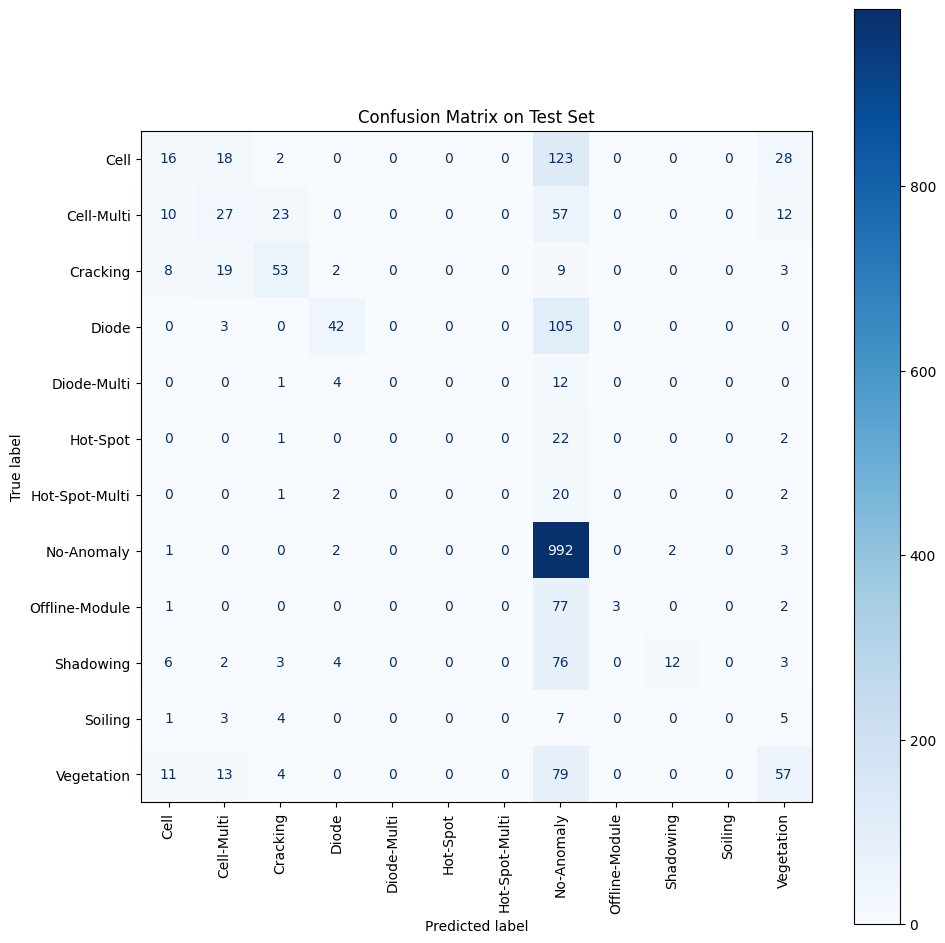

✔️ Confusion matrix generated and displayed.


In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# 7. Generate the confusion matrix
cm = confusion_matrix(all_true_labels, all_predicted_labels)

# 8. Display the confusion matrix
fig, ax = plt.subplots(figsize=(10, 10))
disp = ConfusionMatrixDisplay.from_predictions(
    all_true_labels, all_predicted_labels,
    display_labels=unique_classes,
    xticks_rotation='vertical',
    cmap=plt.cm.Blues,
    ax=ax
)
plt.title('Confusion Matrix on Test Set')
plt.tight_layout()
plt.show()

print("✔️ Confusion matrix generated and displayed.")

## Summarize Results and Discussion

### Subtask:
Provide a markdown section summarizing the key findings from the model training and evaluation. Discuss the strengths and limitations of using VGG-19 for this specific dataset and task. Suggest potential improvements or alternative approaches, such as different architectures or transfer learning strategies.


## Summary:

### Data Analysis Key Findings

*   The VGG-19 model was successfully trained for 20 epochs, achieving a best validation accuracy of 59.05% during the training phase.
*   Upon evaluation on the unseen test set, the model yielded an overall test accuracy of 60.10%.
*   The macro-averaged F1-score on the test set was 0.23, indicating that while the overall accuracy might seem moderate, the model struggled with balanced performance across all classes, likely performing poorly on certain specific classes.
*   Training and validation loss and accuracy curves were plotted, showing the model's learning progression over the epochs.
*   A confusion matrix was generated, providing a detailed visualization of the model's classification performance for each class on the test set.

### Insights or Next Steps

*   **Investigate Class-wise Performance**: The significant difference between overall accuracy ($\sim60\%$) and macro-averaged F1-score (0.23) suggests severe class imbalance or very poor performance on a subset of classes. A detailed analysis of the confusion matrix to identify which classes the model struggles with is crucial.
*   **Explore Advanced Techniques**: Given the current performance, consider exploring techniques such as advanced data augmentation, adjusting class weights in the loss function, or trying different pre-trained architectures (e.g., ResNet, EfficientNet) and fine-tuning strategies to improve both overall accuracy and class-wise F1-score.
